# Visualizing Video Model Outputs

In this notebook we will visualize the outputs of a pre-trained VideoGPT model.

In [ ]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
sys.path.append(os.path.dirname(os.path.abspath("")))

import imageio
from IPython.display import Image
import numpy as np

import notebook_utils as nbu
from videogpt.reward_models import LOAD_REWARD_MODEL_DICT

print('Available reward models:', LOAD_REWARD_MODEL_DICT.keys())

Available reward models: dict_keys(['dmc_clen16_fskip1', 'dmc_clen16_fskip2', 'dmc_clen16_fskip4'])


In [12]:
# Load reward model.
rm_key = 'dmc_clen16_fskip4'
reward_model = LOAD_REWARD_MODEL_DICT[rm_key](task='dmc_cheetah_run')

Reward model devices: gpu:0
Found class_map at [/shared/wilson/logs/viper/videogpt-dmc-l4-s4/class_map.pkl]:
Available tasks: ['acrobot_swingup', 'cartpole_balance', 'cartpole_swingup', 'cheetah_run', 'cup_catch', 'finger_spin', 'finger_turn_hard', 'hopper_stand', 'manipulator_bring_ball', 'pendulum_swingup', 'pointmass_easy', 'pointmass_hard', 'quadruped_run', 'quadruped_walk', 'reacher_easy']
Found desired task cheetah_run: 3
finished loading VideoGPTRewardModel:
	seq_len: 16
	class_cond: True
	task: cheetah_run
	model: videogpt
	camera_key: image
	seq_len_steps: 16
	mask? False
	mask path: /shared/wilson/logs/viper/videogpt-dmc-l4-s4/mask.npy
	task_id: 3
	n_skip? 4


In [13]:

# Load sample sequences to serve as conditioning frames.
seqs = nbu.get_sequences(
    sequence_dir='/shared/ale/datasets/distill/dmc_unfiltered/dm_dmc_cheetah_run1678145762/saved_episodes/',
    min_rew=0,
    min_ep_len=900,
    max_ep=1)

Loading episodes from /shared/ale/datasets/distill/dmc_unfiltered/dm_dmc_cheetah_run1678145762/saved_episodes/
Found 12116 episode files


100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

Found 1 episodes with reward in [0, inf]


Saved video to /tmp/in_domain/test.gif


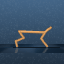

: 

In [18]:
# Play sampled video.
id = 0
file = f'/tmp/in_domain/test.gif'
image_list = [seqs[id][j]["image"] for j in range(len(seqs[id]))]
imageio.mimsave(file, image_list, duration=50, loop=0)
print(f'Saved video to {file}')
display(Image(data=open(file,'rb').read(), format='png', width=500, height=500))

In [15]:
# Gather conditioning frames.
num_samples = 1
num_conditioning_frames = 12
cond_frames = min(num_conditioning_frames, reward_model.seq_len_steps - 1)
init_frames = []
for i in range(num_samples):
    init_frames.append(np.stack([seqs[i][j][reward_model.camera_key] for j in range(cond_frames)][::reward_model.n_skip]))
init_frames = np.stack(init_frames)
init_frames.shape

(1, 3, 64, 64, 3)

In [16]:
# Perform inference with the videogpt model.
frames = reward_model.rollout_video(init_frames, 90, seed=20, pbar=True, open_loop_ctx=num_conditioning_frames // reward_model.n_skip)

Latents of shape (16, 16)


100%|██████████| 86/86 [00:28<00:00,  2.97it/s]


Saved video to /tmp/generalization/test_0.gif


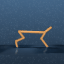

In [17]:
# Visualize result.
for i in range(num_samples):
    file = f'/tmp/generalization/test_{i}.gif'
    image_list = [frames[i][j] for j in range(frames.shape[1])]
    imageio.mimsave(file, image_list, duration=50, loop=0)
    print(f'Saved video to {file}')
    display(Image(data=open(file,'rb').read(), format='png', width=500, height=500))